# Jansen–Rit Single-Node Simulation

This notebook reproduces and expands on the example in `examples/jansenrit_single_node_simulation.py`, turning it into an interactive, well-documented exploration.

We simulate a single Jansen–Rit (JR) neural mass model node under a variety of inputs to illustrate different regimes: baseline alpha-like rhythms, sinusoidal entrainment, spike–wave-like activity, reduced inhibition, and irregular/noisy dynamics.

The JR model captures mesoscopic cortical column activity using three interacting subpopulations:
- Excitatory pyramidal cells (P) — principal output population;
- Excitatory interneurons (E) — provide excitatory feedback to P;
- Inhibitory interneurons (I) — provide inhibitory feedback to P.

Each subpopulation transforms incoming pulse-density (in Hz) through a synaptic impulse response (with gains and time constants) into membrane potentials (in mV), and a sigmoid nonlinearity maps potentials back to pulse-density. The model’s macroscopic EEG-like output is typically taken as a scaled difference between excitatory and inhibitory postsynaptic potentials onto pyramidal cells.


## Setup
- Import `brainmass` (JR implementation), `brainstate` (simulation/runtime control), `brainunit` for units, and plotting utilities.
- Set the global integration step `dt` to 0.5 ms.
- Define a small helper to plot the pyramidal (M), excitatory (E), inhibitory (I) membrane potentials and the EEG-like output.

In [2]:
import brainstate
import brainmass
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

# Set simulation time step
brainstate.environ.set(dt=0.5 * u.ms)

def show(times, data, title):
    M, E, I, eeg = data
    fig, gs = braintools.visualize.get_figure(4, 1, 1.2, 10)
    fig.add_subplot(gs[0, 0])
    plt.plot(times, M)
    plt.ylabel('M (mV)')

    fig.add_subplot(gs[1])
    plt.plot(times, E)
    plt.ylabel('E (mV)')

    fig.add_subplot(gs[2])
    plt.plot(times, I)
    plt.ylabel('I (mV)')

    fig.add_subplot(gs[3])
    plt.plot(times, eeg)
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG (mV)')

    plt.suptitle(title)
    plt.show()


## Notes on inputs and noise
- Inputs to the JR node (`E_inp`) are specified in Hz, representing background afferent pulse density.
- We generate Gaussian white-noise-like inputs using `brainstate.random.normal(mean, std_per_step, shape) * u.Hz`.
- To maintain step-size–independent noise intensity, the standard deviation scales as `std / sqrt(dt)` where `dt` is in seconds. This follows the usual discretization of a white noise process.

We retrieve `dt` from `brainstate.environ.get_dt()` when constructing input arrays and time axes.

## 1) Alpha-like baseline oscillation
A single JR node with default parameters and moderate noisy drive exhibits an alpha-like rhythm (8–12 Hz).
- Model: `brainmass.JansenRitModel(1)` builds one node (one cortical column).
- Initialization: `brainstate.nn.init_all_states(node)` sets internal states consistently.
- Drive: mean 120 Hz with noise SD ≈ 30 Hz per sqrt(second), scaled per time step.
- Duration: 10 seconds.

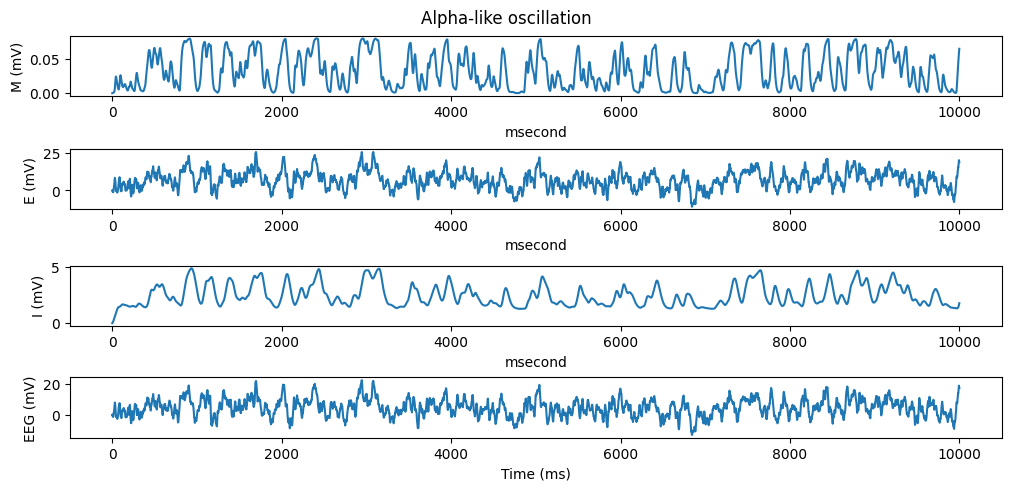

In [3]:
# Alpha-like idle rhythm (baseline JR)
node = brainmass.JansenRitStep(1)
brainstate.nn.init_all_states(node)

def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(120., 30. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Alpha-like oscillation')


## 2) Sinusoidally driven/entrained oscillation
Adding a sinusoidal component to the input can entrain the JR node. Here we drive with a 10 Hz sinusoid around a baseline of ~80 Hz.
- Drive: `inp(t) = 80 + 70 sin(2π f t)` Hz with `f = 10 Hz`.
- Duration: 5 seconds.

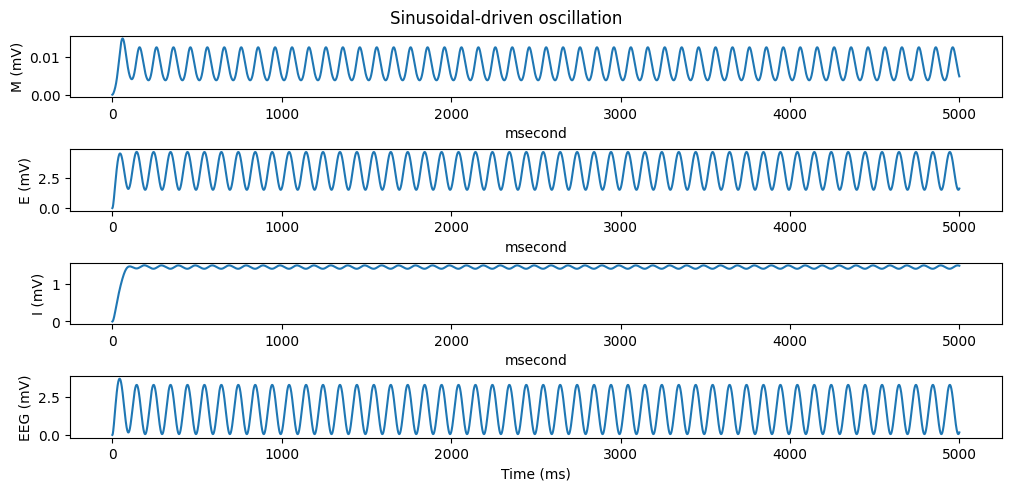

In [4]:
node = brainmass.JansenRitStep(1)
brainstate.nn.init_all_states(node)
f_drive = 10. * u.Hz

def step_run(i):
    tt = i * dt
    inp = 80 + 70.0 * u.math.sin(2 * u.math.pi * f_drive * tt)
    eeg = node.update(E_inp=inp * u.Hz)
    return node.M.value, node.E.value, node.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(5. * u.second / dt))
data = brainstate.transform.for_loop(step_run, indices)
show(indices * dt, data, title='Sinusoidal-driven oscillation')


## 3) Spike–wave-like regime
Changing synaptic gains and time constants can push the node into a spike–wave-like regime reminiscent of epileptiform dynamics.
- Gains: increase excitatory gain `Ae` and reduce inhibitory gain `Ai` relative to typical JR defaults.
- Time constants: set inhibitory inverse time constant `bi` to 40 Hz (slower than the usual 50–100 Hz range), favoring prolonged inhibitory kinetics.
- Drive: mean 90 Hz with moderate noise.
- Duration: 10 seconds.

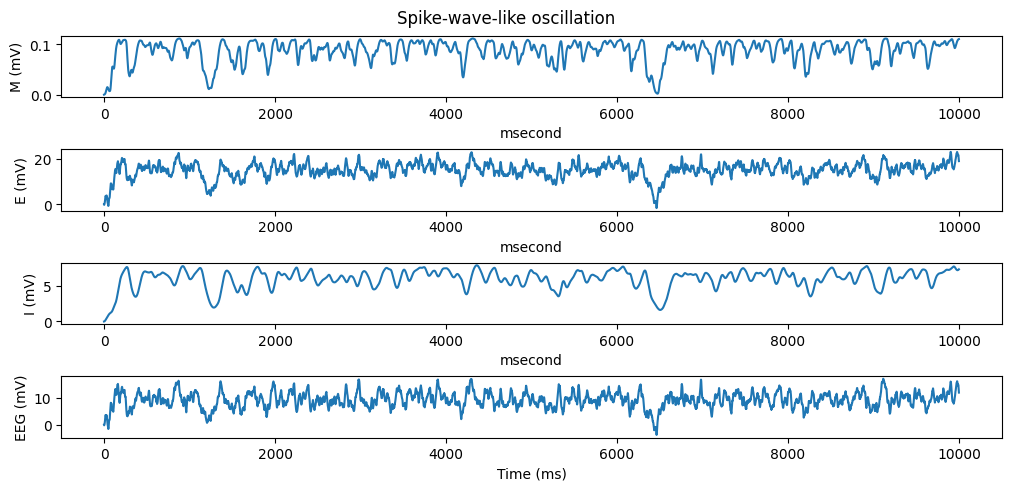

In [5]:
node = brainmass.JansenRitStep(1, Ae=4.5 * u.mV, Ai=18. * u.mV, bi=40. * u.Hz)
brainstate.nn.init_all_states(node)

def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(90., 10. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Spike-wave-like oscillation')


## 4) Reduced inhibition (disinhibited)
Lowering inhibitory strength typically increases oscillation amplitude and can shift frequency.
- Parameters: lower `Ai` and use `bi = 40 Hz`.
- Drive: mean 100 Hz with noise SD ≈ 20 Hz per sqrt(second).
- Duration: 10 seconds.

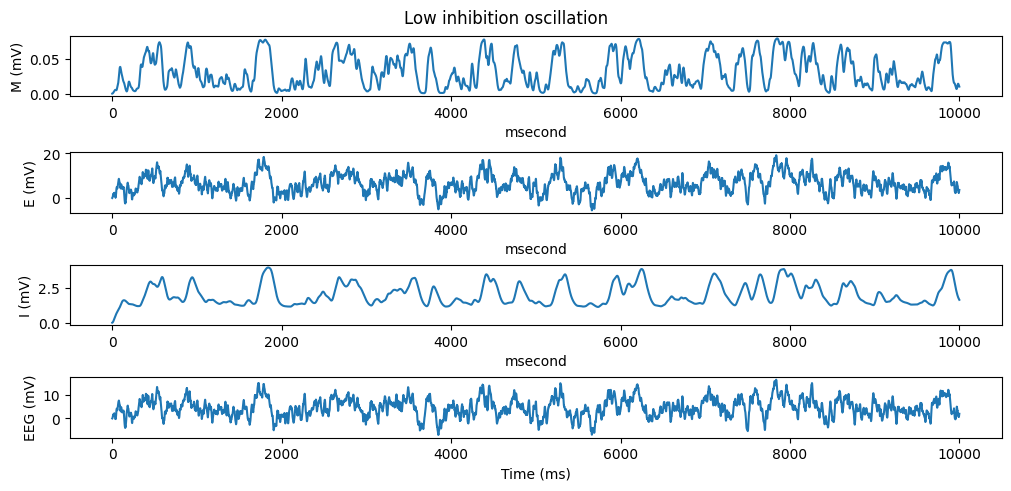

In [6]:
node = brainmass.JansenRitStep(1, Ai=15. * u.mV, bi=40. * u.Hz)
brainstate.nn.init_all_states(node)

def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(100., 20. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Low inhibition oscillation')


## 5) Irregular/noisy regime
Increasing mean drive and noise level yields more irregular, broadband dynamics.
- Drive: mean 220 Hz with high noise SD ≈ 80 Hz per sqrt(second).
- Duration: 10 seconds.

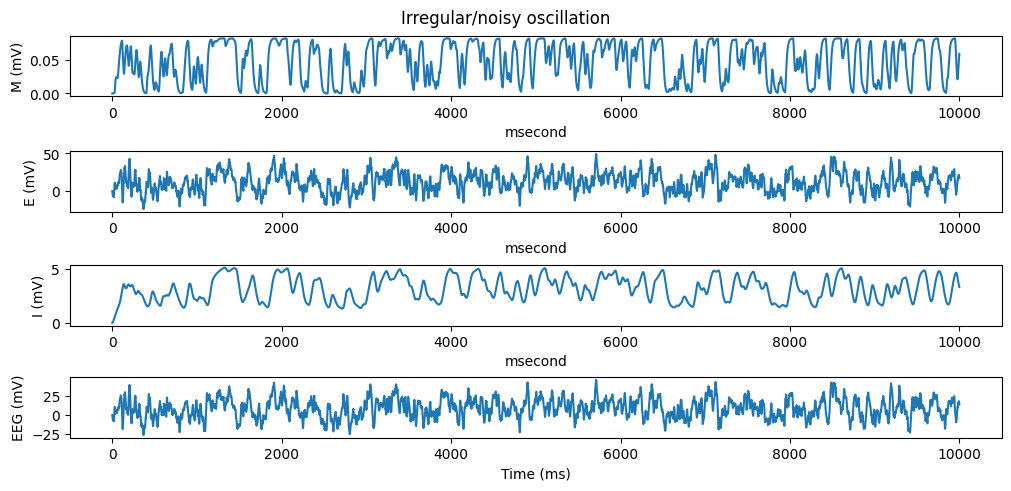

In [7]:
node = brainmass.JansenRitStep(1)
brainstate.nn.init_all_states(node)

def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(10 * u.second / dt))
inputs = brainstate.random.normal(220., 80. / (dt / u.second) ** 0.5, indices.shape) * u.Hz
data = brainstate.transform.for_loop(step_run, inputs)
show(indices * dt, data, title='Irregular/noisy oscillation')


## Tips
- Change `dt` under the Setup cell to trade accuracy for speed (smaller `dt` is slower but more precise).
- Try different `Ae`, `Ai`, `be`, `bi` parameters when constructing `JansenRitModel` to explore bifurcations.
- Replace the noisy input with deterministic waveforms (ramps, chirps) to test entrainment and resonance.
- For reproducible noise, set the random seed if available in your `brainstate` version (e.g., `brainstate.random.seed(0)`).